# Nuages de mots

## Imports et stopwords

In [112]:
import os
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer


In [113]:
# Téléchargement des ressources NLTK si nécessaire
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/ilaria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilaria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [114]:
# stopwords français
sw = set(stopwords.words('french'))

In [115]:
# Stopwords OCR + bruit journalistique
sw |= {
  "bruxelles", "brux", "rue", "tél", "tel", "adresse",
    "soir", "matin", "jour", "hier", "demain",
    "prix", "vente", "achat", "maison",
    "samedi", "dimanche", "lundi", "mardi",
    "mercredi", "jeudi", "vendredi",
    "rossel", "belga", "afp",
    "hmu", "xix", "xii", "xxe", "xxx",
    "film", "théâtre", "cinéma", "concert",
    "halloween", "costume",
    "ville", "place", "travail",
    "-", "plus", "cette", "tout", "deux", "comme", "sans", "bien",
    "tous", "grand", "fait", "programme", "heures", "après", "van",
    "dont", "être", "très", "non", "aussi", "ans", "sous", "france",
    "encore", "monde", "faire", "cours", "trois", "ena", "autres",
    "entre", "avant", "cela", "alors", "même", "cela", "depuis", "après",
    "peu", "fois", "jours", "ainsi", "dire", "autre", "année", "année",
    "année", "année", "année", "année", "année", "année", "année", "année", "année"
}

# Stopwords hors-thématique (évite les nuages inutiles)
sw |= {
    "film", "théâtre", "cinéma", "concert",
    "halloween", "costume",
    "ville", "place", "travail"
}


### Nettoyage du texte

In [116]:
# Fonction de nettoyage du texte
def nettoyer_texte(text):
    """
    Nettoie le texte : enlève ponctuation, chiffres, mots très courts, espaces multiples.
    """
    text = re.sub(r'[^\w\s\-àâäéèêëîïôöùûüç]', ' ', text)
    text = text.lower()
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\b\w{1,2}\b', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def filter_words(words):
    return [w for w in words if w.isalpha() and w not in sw and len(w) > 2]



In [117]:
# chjarger le fichers et lister les fichiers 
data_path = "../../data/txt_tp4"
files = [f for f in os.listdir(data_path) if f.endswith(".txt")]
print("Nombre de fichiers thématiques =", len(files))

def extract_year(filename):
    """
    Extrait l'année d'un fichier au format :
    KB_JB838_1966-08-03_01-00008.txt
    """
    parts = filename.split("_")
    for part in parts:
        if re.match(r"(19|20)\d{2}-\d{2}-\d{2}", part):
            return int(part[:4])
    return None


Nombre de fichiers thématiques = 999


### Créer un texte global pour générer le nuage

In [118]:
corpus = []
corpus_decennies = {}

for f in files:
    year = extract_year(f)
    if year is None:
        continue
    
    dec = (year // 10) * 10

    with open(os.path.join(data_path, f), "r", encoding="utf-8") as ff:
        text = nettoyer_texte(ff.read())
    
    words = filter_words(text.split())
    
    corpus.extend(words)
    
    corpus_decennies.setdefault(dec, [])
    corpus_decennies[dec].append(" ".join(words))

print("Décennies disponibles :", sorted(corpus_decennies.keys()))
print("Nombre de mots corpus global :", len(corpus))


Décennies disponibles : [1950, 1960, 1970]
Nombre de mots corpus global : 2448417


### Nouage de mots globale

[('musique', 7773), ('paris', 3101), ('homme', 3088), ('belgique', 3067), ('orchestre', 3053), ('temps', 3051), ('etc', 3037), ('jean', 3035), ('enf', 2958), ('theatre', 2942), ('enfants', 2924), ('vie', 2881), ('contre', 2764), ('premier', 2751), ('leurs', 2733), ('grande', 2633), ('première', 2613), ('pays', 2595), ('femme', 2583), ('mois', 2578), ('peut', 2575), ('part', 2459), ('libre', 2435), ('toute', 2432), ('moins', 2423), ('avenue', 2419), ('chez', 2399), ('bon', 2397), ('œuvre', 2390), ('français', 2365)]


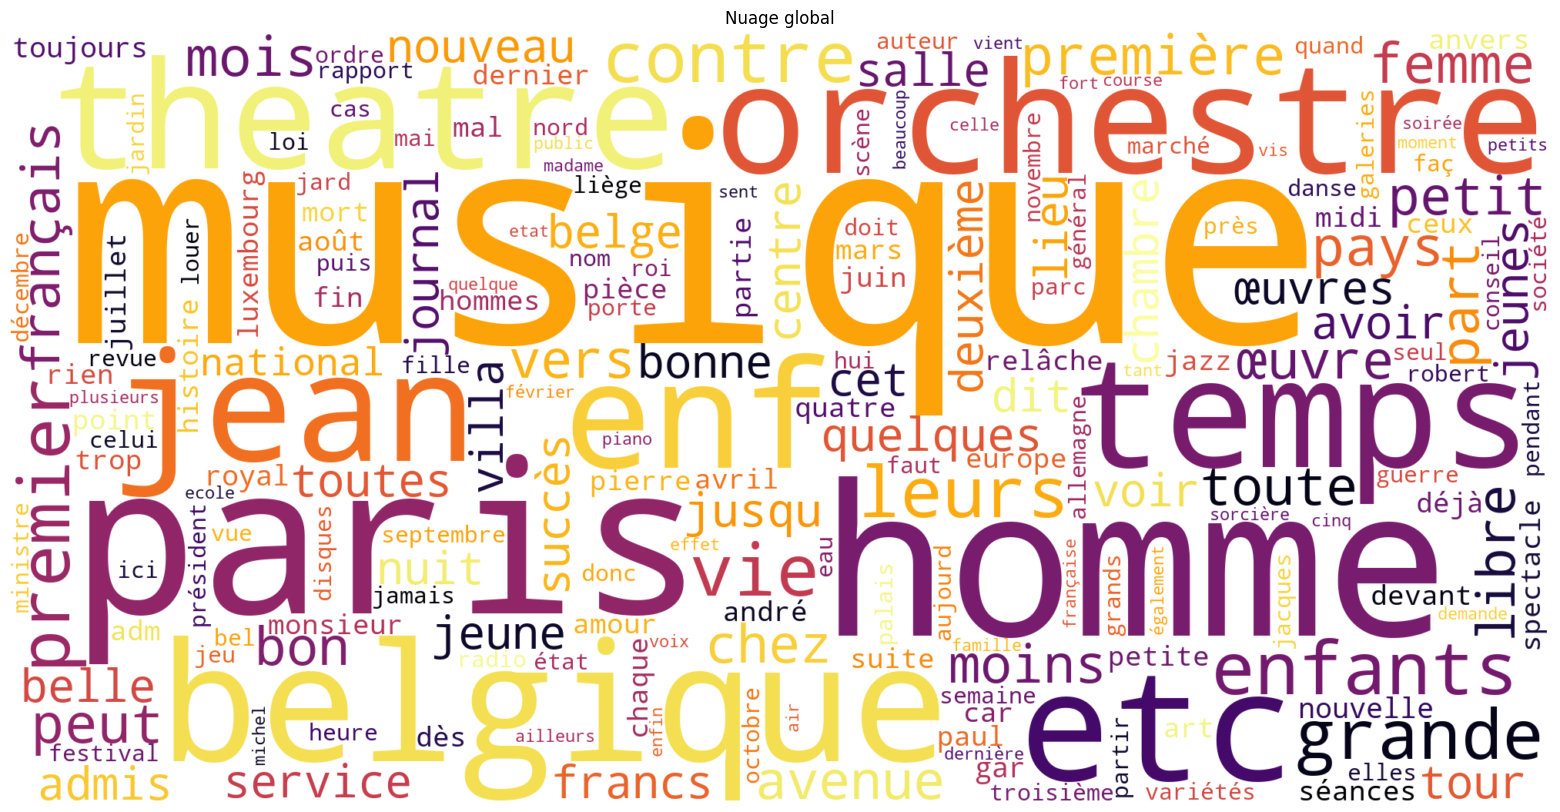

In [119]:
frequencies = Counter(corpus)
print(frequencies.most_common(30))

cloud = WordCloud(
    width=2000, height=1000,
    background_color='white',
    colormap='inferno'
).generate_from_frequencies(frequencies)

plt.figure(figsize=(20,10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage global")
plt.show()


### Nouages de mots par decennie

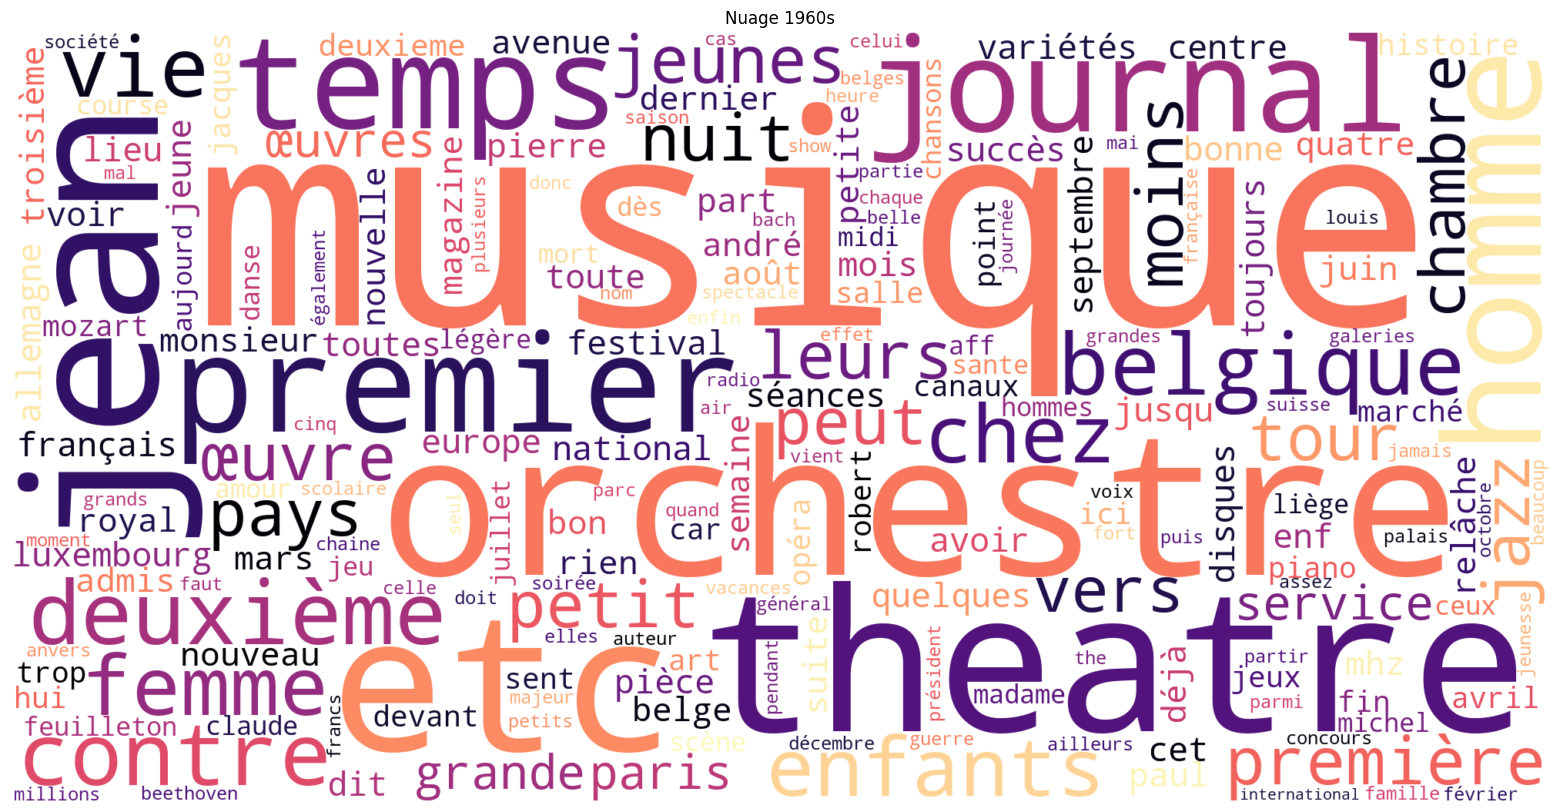

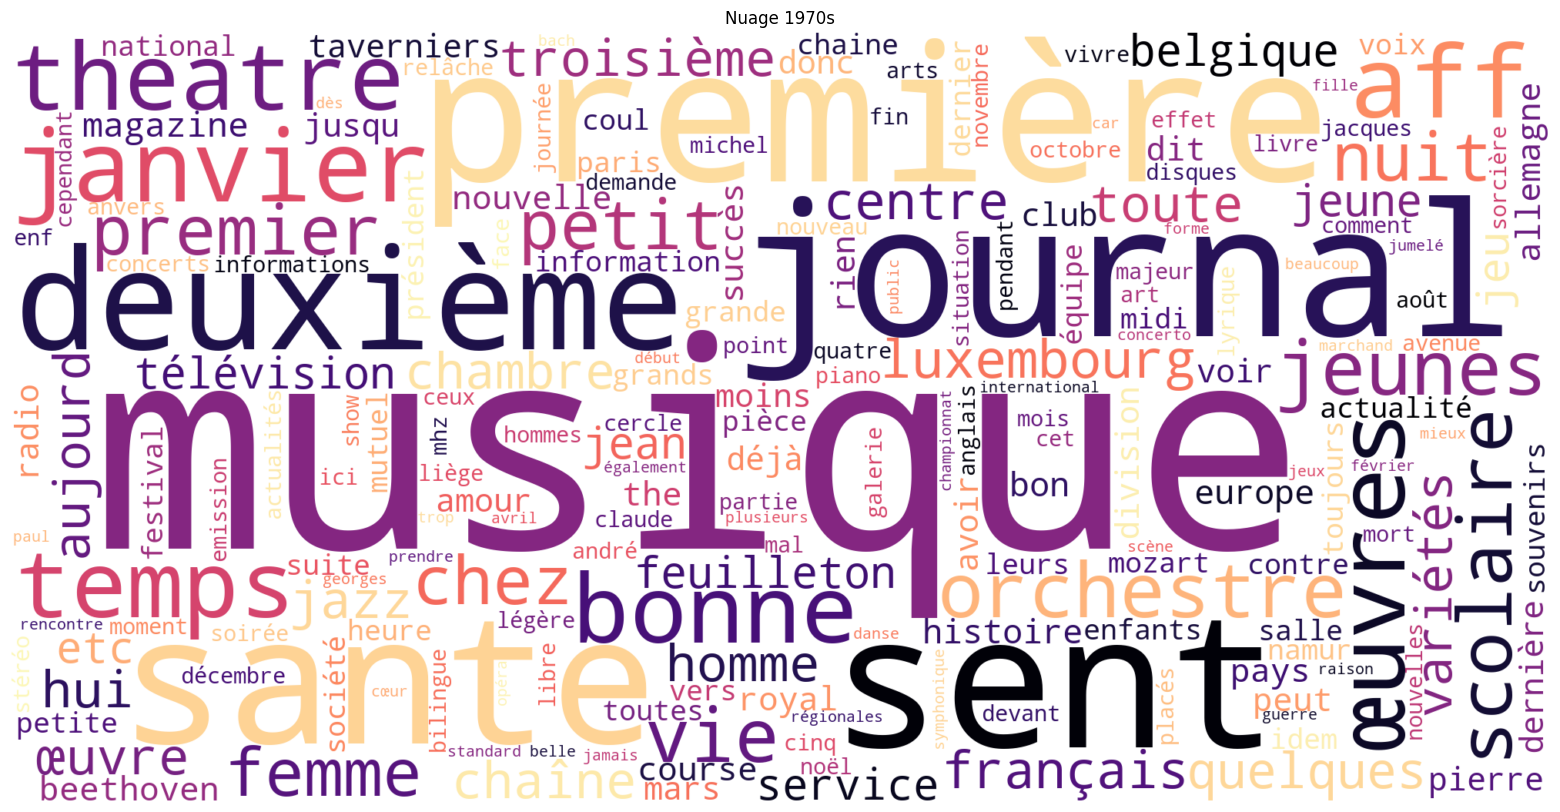

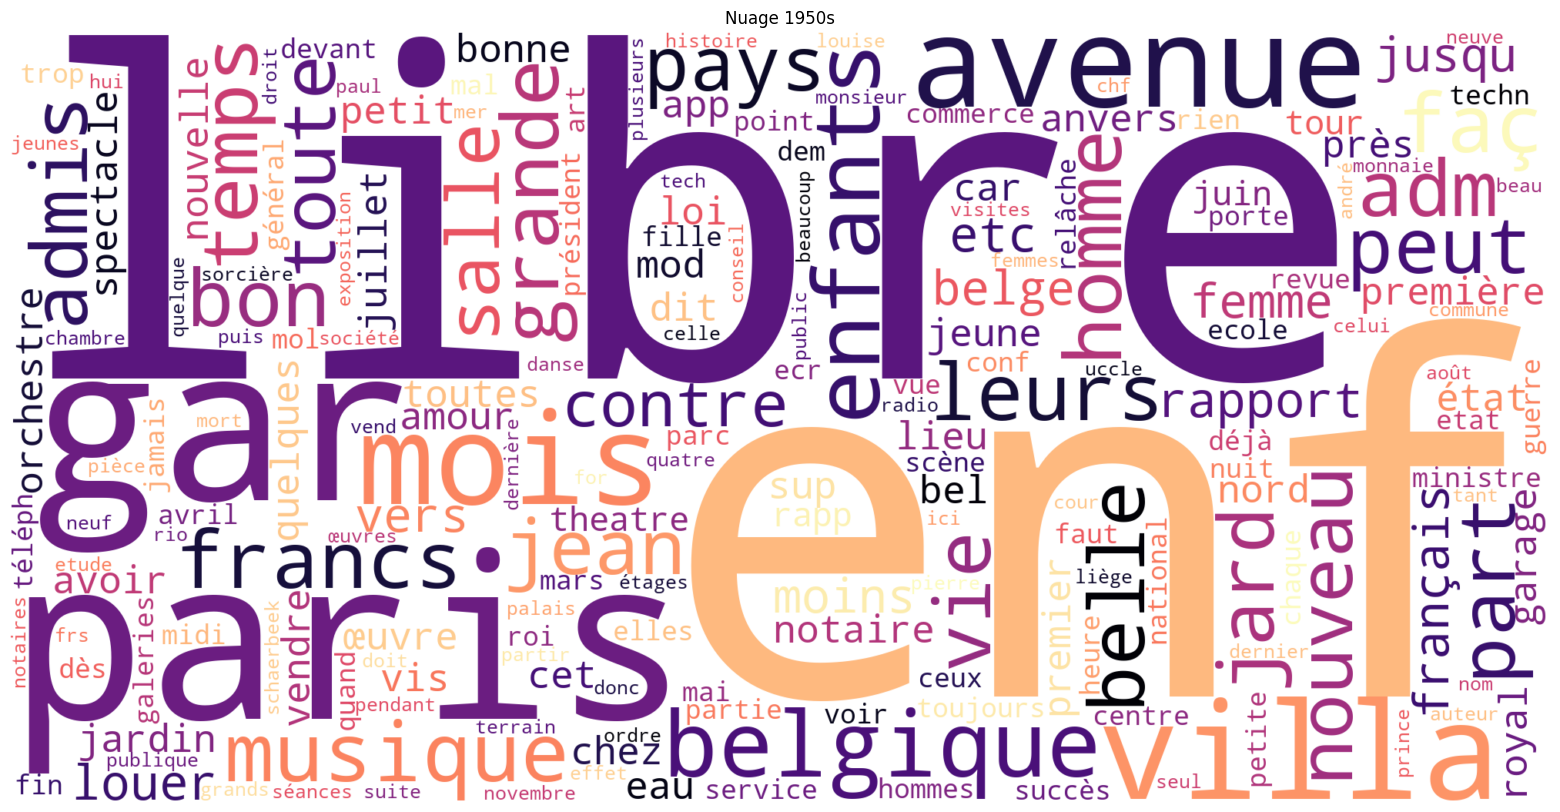

In [120]:
for dec, textes in corpus_decennies.items():
    words_dec = filter_words(" ".join(textes).split())
    freq_dec = Counter(words_dec)
    
    cloud_dec = WordCloud(
        width=2000, height=1000,
        background_color='white',
        colormap='magma'
    ).generate_from_frequencies(freq_dec)
    
    plt.figure(figsize=(20,10))
    plt.imshow(cloud_dec, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Nuage {dec}s")
    plt.show()


### TF-IDF sur corpus global

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer

global_text = [" ".join(corpus)]
vectorizer = TfidfVectorizer(max_features=50)
X = vectorizer.fit_transform(global_text)
tfidf_scores = dict(zip(vectorizer.get_feature_names_out(), X.toarray()[0]))

sorted_words = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)
print(sorted_words)


[('musique', np.float64(0.4045761530522169)), ('paris', np.float64(0.1614036601846037)), ('homme', np.float64(0.16072702439537445)), ('belgique', np.float64(0.15963399735123493)), ('orchestre', np.float64(0.1589053126551419)), ('temps', np.float64(0.15880121484141435)), ('etc', np.float64(0.15807253014532133)), ('jean', np.float64(0.15796843233159374)), ('enf', np.float64(0.15396066650308216)), ('theatre', np.float64(0.15312788399326155)), ('enfants', np.float64(0.1521910036697134)), ('vie', np.float64(0.14995290067457054)), ('contre', np.float64(0.14386317857150746)), ('premier', np.float64(0.14318654278227821)), ('leurs', np.float64(0.14224966245873005)), ('grande', np.float64(0.13704477177235136)), ('première', np.float64(0.13600379363507561)), ('pays', np.float64(0.13506691331152745)), ('femme', np.float64(0.13444232642916198)), ('mois', np.float64(0.13418208189484307)), ('peut', np.float64(0.1340259351742517)), ('part', np.float64(0.1279882619780524)), ('libre', np.float64(0.12673